# Binary Classification of Cells Using Logistic Regression


In [1]:
import sys
import os
import tarfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print('Python version     :', '{0[0]}.{0[1]}'.format(sys.version_info))
print('Tensorflow version :', tf.__version__)
print('numpy version      :', np.__version__)

Python version     : 3.6
Tensorflow version : 1.4.0
numpy version      : 1.13.3


## Dataset

Our dataset consists of total of over 12,000 cells with a total of 2 categories; over 2,000 cells in sequential category  (labelled SQNC) and over 10,000 in combinational category (labelled COMB). 
Each cell in the dataset is represented as a 2D matrix of transistor devices and their parameters given below:


| Device | param1 | param2 | param3 | param4 | param5 | ...... | ...... | param13 |
|--------|--------|--------|--------|--------|--------|--------|--------|---------|
|   10   |    6   |    6   |    3   |    3   |    5   |        |        |    2    |
|   10   |    8   |    3   |    2   |    4   |    4   |    2   |    3   |    6    |
|   20   |    7   |    3   |    2   |    4   |    4   |    2   |    3   |    2    |
|  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...    |
|  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...    |
|   20   |    7   |    3   |    2   |    4   |    5   |    2   |    3   |    2    |

We are arbitrarily selecting only 5 of these parameters as features to improve performance.

In [2]:
# max_devices_per_cell is also max number of rows in circuit files in the training set
max_devices_per_cell = 351; 
# feature_per_device is different from max number of cols (14) in circuit files in training set
feature_per_device   = 5; 
feature_indices = (0,2,5,8,11)

def load_one_cell(cell_file):
    cell_cols = 14
    cell_data = np.zeros(shape=(max_devices_per_cell, cell_cols), dtype=np.float32)
    cell_mat  = np.loadtxt(cell_file, dtype=np.float32, ndmin=2)
    nrows     = cell_mat.shape[0]
    ncols     = cell_mat.shape[1]
    cell_data[:nrows, :ncols] = cell_mat
    cell_data = cell_data[:, feature_indices]
    return cell_data

In [3]:
def load_cells(folder):
  #Load the data for a single label.
  cell_files = os.listdir(folder)
  dataset = np.zeros(shape=(len(cell_files), max_devices_per_cell, feature_per_device),
                         dtype=np.float32)
  cell_index = 0
  for cell in cell_files:
    cell_file = os.path.join(folder, cell)
    try:
      cell_data = load_one_cell(cell_file)

      cell_rows = cell_data.shape[0]
      cell_cols = cell_data.shape[1]
      dataset[cell_index, :cell_rows, :cell_cols] = cell_data

      cell_index = cell_index + 1
    except IOError as e:
      print('Could not read:', cell_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:cell_index, :, :]

  print(os.path.basename(folder), ': shape=', dataset.shape, ', Mean=', np.mean(dataset), ', sigma=', np.std(dataset))
  return dataset

comb_dataset = load_cells(os.path.join('..','data','2classes','COMB'))
sqnc_dataset = load_cells(os.path.join('..','data','2classes','SQNC'))

COMB : shape= (10096, 351, 5) , Mean= 0.686939 , sigma= 2.95702
SQNC : shape= (2096, 351, 5) , Mean= 1.36903 , sigma= 4.67975


# Create Labels

In [4]:
# create one hot labels
#         COMB_LABEL=[1.0, 0.0], SQNC_LABEL=[0.0, 1.0]
labels = np.asarray([[1.0, 0.0] if (i<comb_dataset.shape[0]) else [0.0, 1.0] for i in range(comb_dataset.shape[0]+sqnc_dataset.shape[0])])

# Randomize Dataset

In [5]:
# randomize comb and sqnc dataset
np.random.shuffle(comb_dataset)
np.random.shuffle(sqnc_dataset)

# Create a combined dataset
dataset = np.append(comb_dataset, sqnc_dataset, axis=0)

# randomize dataset and labels together to keep'em in sync.
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

# randomize dataset
dataset, labels = randomize(dataset, labels)

print('Full dataset: no. of cells=', dataset.shape, 'Min=', np.min(dataset), 'Max=',np.max(dataset), 
      'Mean=', np.mean(dataset), 'Sigma=', np.std(dataset))

Full dataset: no. of cells= (12192, 351, 5) Min= 0.0 Max= 50.0 Mean= 0.804201 Sigma= 3.32745


# Visualize Dataset
Visualizing your dataset in single dimension gives you clues. Visualizing cells with over 1700 dimensions is a bit overwhelming. So we'll reduce our matrix to a single number including mean, sigma and frobenius norm and see, if there
is a trend.

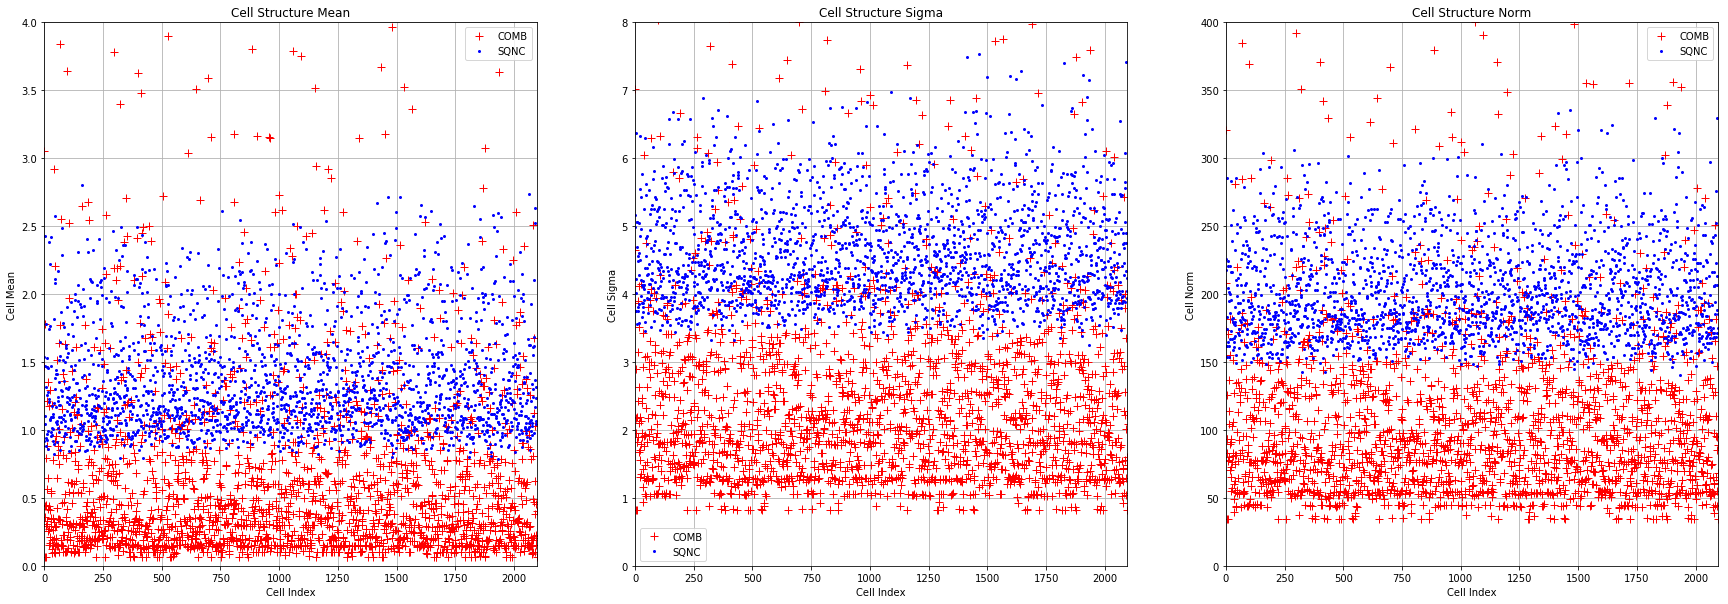

In [6]:
# Frobenius norm of matrices
comb_norms = [np.linalg.norm(cell) for cell in comb_dataset]
sqnc_norms = [np.linalg.norm(cell) for cell in sqnc_dataset]

comb_mean  = [np.mean(cell) for cell in comb_dataset]
sqnc_mean  = [np.mean(cell) for cell in sqnc_dataset]

comb_sigma = [np.std(cell) for cell in comb_dataset]
sqnc_sigma = [np.std(cell) for cell in sqnc_dataset]

comb_size = comb_dataset.shape[0]
sqnc_size = sqnc_dataset.shape[0]

plt.figure(figsize=(30,10))

plt.subplot(1, 3, 1)
plt.grid()
plt.xlim(0,sqnc_size)
plt.ylim(0,4)
plt.plot([i for i in range(comb_size)], comb_mean, 'ro', label='COMB', marker='+', markersize=8)
plt.plot([i for i in range(sqnc_size)], sqnc_mean, 'bo', label='SQNC', marker='.', markersize=4)
plt.title('Cell Structure Mean')
plt.xlabel('Cell Index')
plt.ylabel('Cell Mean')
plt.legend()

plt.subplot(1, 3, 2)
plt.grid()
plt.xlim(0,sqnc_size)
plt.ylim(0,8)
plt.plot([i for i in range(comb_size)], comb_sigma, 'ro', label='COMB', marker='+', markersize=8)
plt.plot([i for i in range(sqnc_size)], sqnc_sigma, 'bx', label='SQNC', marker='.', markersize=4)
plt.title('Cell Structure Sigma')
plt.xlabel('Cell Index')
plt.ylabel('Cell Sigma')
plt.legend()

plt.subplot(1, 3, 3)
plt.grid()
plt.xlim(0,sqnc_size)
plt.ylim(0,400)
plt.plot([i for i in range(comb_size)], comb_norms, 'ro', label='COMB', marker='+', markersize=8)
plt.plot([i for i in range(sqnc_size)], sqnc_norms, 'bo', label='SQNC', marker='.', markersize=4)
plt.title('Cell Structure Norm')
plt.xlabel('Cell Index')
plt.ylabel('Cell Norm')
plt.legend()

plt.show()
plt.close("all")

# Reformat Dataset

In [7]:
def reformat(dataset):
    dataset = dataset.reshape((-1, max_devices_per_cell*feature_per_device))
    return dataset

dataset = reformat(dataset)

# Normalize Dataset

In [8]:
# normalize the dataset between 0 and 1.
data_mean = 0;
data_std  = (np.max(dataset)-np.min(dataset));

def normalize(d, mean, std):
    return (d - mean) / std

def denormalize(d, mean, std):
    return (d * std) + mean

dataset = normalize(dataset, data_mean, data_std)

print('Min=', np.min(dataset), 'Max=',np.max(dataset), 'Mean=',np.mean(dataset), 'sigma=', np.std(dataset))
print(dataset.shape)
#print('dataset feature min vector = ', np.min(dataset, axis=0))
#print('dataset feature max vector = ', np.max(dataset, axis=0))

Min= 0.0 Max= 1.0 Mean= 0.016084 sigma= 0.066549
(12192, 1755)


# Divide dataset
into training dataset and validation dataset

In [9]:
# training dataset percentage is 80%
def divide_dataset(dataset, labels):
    train_pct = 0.8; 
    # divide dataset into training and validation set
    train_index = int(dataset.shape[0]*train_pct)
    t_X = dataset[:train_index, :]
    t_Y = labels[:train_index,:]
    v_X = dataset[train_index:,:]
    v_Y = labels[train_index:,:]
    
    return t_X, t_Y, v_X, v_Y

train_X, train_Y, valid_X, valid_Y = divide_dataset(dataset, labels)

print(train_X.shape)

(9753, 1755)


## Declare Graph Variables

Place to declare plave holders and variables for compute graph

In [10]:
SIGMA      = np.sqrt(2.0/train_X.shape[0])
n_features = train_X.shape[1]
n_labels   = 2


Weights = tf.Variable(tf.truncated_normal(shape=[n_features, n_labels], mean=3.0*SIGMA, stddev=SIGMA, dtype=tf.float32), trainable=True)
Biases  = tf.Variable(tf.constant(value=SIGMA, dtype=tf.float32, shape=[n_labels]), trainable=True)

t_dataset = tf.placeholder(tf.float32, shape=(None, n_features), name='t_dataset');
t_labels  = tf.placeholder(tf.float32, shape=(None, n_labels), name='t_labels'); 

## Compute Graph
Construct a multivariate polynomial model

In [11]:
# Use sigmoid for binary classification and softmax for multiclass classification
predictions        = tf.matmul(t_dataset, Weights) + Biases

t_labels_cls       = tf.argmax(t_labels, axis=1)
predictions_cls    = tf.argmax(predictions, axis=1)
correct_prediction = tf.equal(predictions_cls, t_labels_cls)
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# change it to sigmoid_cross_entropy_with_logits
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=predictions,
                                                        labels=t_labels)

# Hyper parameters

In [12]:
# Hyper parameters
learning_rate = 100
training_epochs = 100
display_step = 10

## Cost function and Optimizer

In [13]:
# Mean squared error
cost = tf.reduce_mean(cross_entropy)

# Gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

## Train the Model

In [14]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    sess.run(optimizer, feed_dict={t_dataset:train_X, t_labels:train_Y})

    #Display logs per epoch step
    if (epoch+1) % display_step == 0:
        c = sess.run(cost, feed_dict={t_dataset:train_X, t_labels:train_Y})
        print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))

print( "\nOptimization Finished!" )

Epoch: 0010 cost= 4.871456146
Epoch: 0020 cost= 0.539853334
Epoch: 0030 cost= 0.164027378
Epoch: 0040 cost= 0.140923843
Epoch: 0050 cost= 0.110866301
Epoch: 0060 cost= 0.088181414
Epoch: 0070 cost= 0.073663294
Epoch: 0080 cost= 0.063479125
Epoch: 0090 cost= 0.058197569
Epoch: 0100 cost= 0.053922810

Optimization Finished!


# Cost and Accuracy

In [15]:
# Find cost on training dataset.
training_cost = sess.run(cost, feed_dict={t_dataset:train_X, t_labels:train_Y})
print ("Training   cost =",training_cost)
validation_cost = sess.run(cost, feed_dict={t_dataset:valid_X, t_labels:valid_Y})
print ("Validation cost =",validation_cost, '\n')

# Find cost on validation dataset.
out, preds, tacc = sess.run([t_labels, predictions, accuracy], feed_dict={t_dataset:train_X, t_labels:train_Y})
print("Training   Accuracy =", tacc)
print("Validation Accuracy =", accuracy.eval(session=sess, feed_dict={t_dataset:valid_X, t_labels:valid_Y}))

Training   cost = 0.0539228
Validation cost = 0.0804923 

Training   Accuracy = 0.991182
Validation Accuracy = 0.9877


# The Model

In [16]:
W = Weights.eval(session=sess)
B = Biases.eval(session=sess)

def classifier(X):
    prediction = (tf.matmul(X, W) + B).eval(session=sess)[0]
    cell_type = 'COMB' if (prediction[0]>prediction[1]) else 'SQNC'
    return cell_type

# Test few cells

We'll test few cells here. Pay attention to incorrectly classified cell AN5_6.mat.

In [17]:
sample_cells = [os.path.join('..','data','2classes','COMB', 'AN2_1.mat'), 
                os.path.join('..','data','2classes','SQNC', 'FSDPRBSBQO_8_9.mat'),
                os.path.join('..','data','2classes','COMB', 'MUX5_CTY2_32_9.mat'),
                os.path.join('..','data','2classes','COMB', 'OAI22_TY2_16.mat'),
                os.path.join('..','data','2classes','COMB', 'MUX5_CTY2_24_1.mat'),
                os.path.join('..','data','2classes','COMB', 'AN5_6.mat'),
                os.path.join('..','data','2classes','COMB', 'MUX3_CTY2_32.mat'),
                os.path.join('..','data','2classes','SQNC', 'FSDNQ_V2_1.mat')]

for cell_file in sample_cells:
    cell_data = reformat(load_one_cell(cell_file))
    print (cell_file.ljust(40), 'CLASS is :', classifier(cell_data))

..\data\2classes\COMB\AN2_1.mat          CLASS is : COMB
..\data\2classes\SQNC\FSDPRBSBQO_8_9.mat CLASS is : SQNC
..\data\2classes\COMB\MUX5_CTY2_32_9.mat CLASS is : COMB
..\data\2classes\COMB\OAI22_TY2_16.mat   CLASS is : COMB
..\data\2classes\COMB\MUX5_CTY2_24_1.mat CLASS is : COMB
..\data\2classes\COMB\AN5_6.mat          CLASS is : SQNC
..\data\2classes\COMB\MUX3_CTY2_32.mat   CLASS is : COMB
..\data\2classes\SQNC\FSDNQ_V2_1.mat     CLASS is : SQNC


# Confusion Matrix

[[8028   65]
 [  21 1639]]


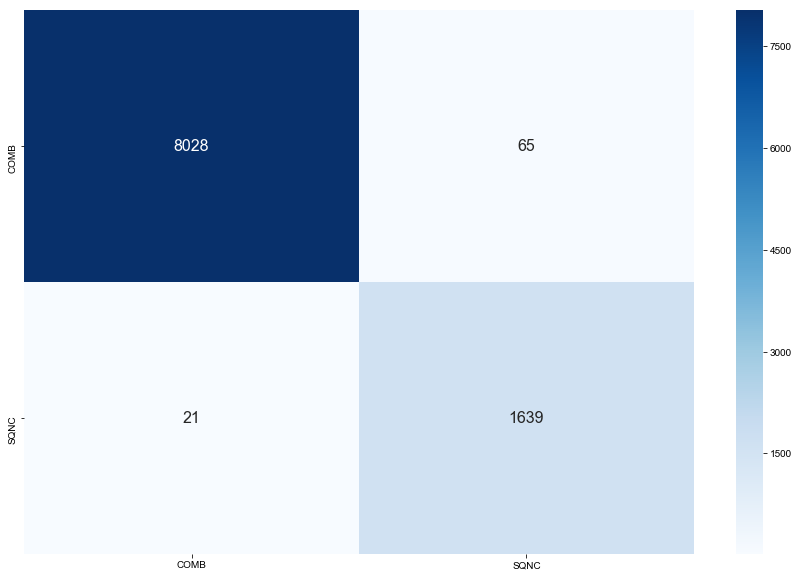

In [18]:
cm = tf.confusion_matrix(labels=tf.argmax(train_Y, axis=1), predictions=tf.argmax(preds, axis=1), num_classes=2)
cm_ary = cm.eval(session=sess)
print(cm_ary)

# Plot confusion matrix
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(cm_ary, index = [i for i in ['COMB', 'SQNC']], columns = [i for i in ['COMB', 'SQNC']])
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 16})# font size
sn.set(font_scale=1.4)#for label size
plt.show()

In [19]:
sess.close()